## Εργασία 3

In [1]:
import nltk
!rm -rf /usr/share/nltk_data/corpora/wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [2]:
# Import basic libraries
import string
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn            #Base class for all neural network modules
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import optuna
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, auc
from tqdm import tqdm
from sklearn import metrics
import os
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, BertConfig
import time
import datetime
import seaborn as sns
from optuna.samplers import GridSampler
from scipy.special import softmax

2025-05-20 10:24:37.028467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747736677.212972      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747736677.266653      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Random Seed at file level for reproducibility
random_seed = 137

np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)  # we add torch seed
torch.cuda.manual_seed(random_seed)

# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
# Set a fixed value for the hash seed
os.environ['PYTHONHASHSEED'] = str(random_seed)
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)

In [ ]:
# Import the data
df_train = pd.read_csv('YOUR PATH TO: train_dataset.csv')    # returns a dataframe
df_val = pd.read_csv('YOUR PATH TO: val_dataset.csv')
df_test = pd.read_csv('YOUR PATH TO: test_dataset.csv')

In [6]:
X_train, y_train = df_train["Text"], df_train["Label"]    # corresponds tuples
X_val, y_val = df_val["Text"], df_val["Label"]
X_test, X_test_id = df_test["Text"], df_test["ID"]

In [7]:
# Preprocessing (all the functions we'll need):
# We tokenize, so that we can preprocess
def my_split(str_arg):
    return str_arg.split(' ')

# lowercase
def my_lower(list_arg):
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = list_arg[i].lower()
    return list_arg

# stop word removal
def my_stopword(list_arg):
    clean_list = []
    for word in list_arg:
        if word not in stopwords.words('english'):
            clean_list.append(word)
    return clean_list

# Lemmatization.
def my_lemmatize(list_arg):
    lemmatizer = WordNetLemmatizer()
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = lemmatizer.lemmatize(list_arg[i])
    return list_arg

# Remove special characters and punctuation
def my_unpunct(list_arg):
    length = len(list_arg)
    for i in range(length):
        list_arg[i] = ''.join([ch for ch in list_arg[i] if ch not in string.punctuation])
    return list_arg

def my_join(list_arg):
    return " ".join(list_arg)    # this is a string function

def my_preprocess(X_set):
    # See report on why certain functions are commented!
    X_set = X_set.apply(my_split)       # we tokenize, so that we can preprocess
    X_set = X_set.apply(my_lower)       # we lowercase
    X_set = X_set.apply(my_stopword)    # we remove stop words
    X_set = X_set.apply(my_lemmatize)   # we lemmatize
    X_set = X_set.apply(my_unpunct)     # we remove special characters and punctuation 
    X_set = X_set.apply(my_join)        # we join all the tokens of one sentence together
    return X_set

In [8]:
# We preprocess train, validation and test set
# X_train = my_preprocess(X_train)
# X_val = my_preprocess(X_val)
# X_test = my_preprocess(X_test)

In [9]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)  # do_lower_case is set to True by default

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Βρίσκουμε το μέγιστο μήκος πρότασης στο X_set, included the [CLS], [SEP] tokens
def max_sentence_lenght(X_set):
    max_len = 0

    # For every sentence...
    for sent in X_set:

        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = tokenizer.encode(sent, add_special_tokens=True)

        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    # print('Max sentence length: ', max_len)
    return max_len

In [11]:
max_len_train = max_sentence_lenght(X_train)
max_len_val = max_sentence_lenght(X_val)
max_len_test = max_sentence_lenght(X_test)
max_len_sent = max(max_len_train, max_len_val, max_len_test)
print('Max sentence length in X_train, X_val, X_test: ', max_len_sent)

Max sentence length in X_train, X_val, X_test:  304


In [12]:
# Συνάρτηση που εφαρμόζει την encode_plus στο X_set, μετατρέπει το y_set σε tensor, και επιστρέφει ένα TensorDataset
def my_encode_plus_dataset(max_len_sent, X_set, y_set):
    # Tokenize all of the sentences and map the tokens to their word IDs.
    input_ids = []          # this is a list of tensors
    attention_masks = []    # this is a list of tensors

    # For every sentence...
    for sent in X_set:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_len_sent, # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])   # encoded_dict returns a [1, max_len_sent] tensor

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)  # input_ids is a [num_sentences, max_len_sent] tensor
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y_set)

    # We combine the inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

In [13]:
# We tokenize X_train, X_val and save to TensorDataset
train_dataset = my_encode_plus_dataset(max_len_sent, X_train, y_train)
val_dataset = my_encode_plus_dataset(max_len_sent, X_val, y_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):  # preds is a tensor with one row and two columns (two = binary classification)
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 1. 
Πρόκειται για το πείραμα της ενότητας 3.1.1. του report. Ελέγχουμε αν το preprocessing βοηθά στο αρχικό μας μοντέλο. Δεν υλοποιούμε early stopping, learning rate scheduler, L2 norm clipping. Εκτελούμε το κάθε πείραμα για 1 εποχή, batch size = 32, learning rate = 1e-5, weight decay in AdamW = 0.01 (default).

In [16]:
# # Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

# # Tell pytorch to run this model on the GPU.
# model.cuda()

# epochs = 1              
# batch_size = 32         
# learning_rate = 1e-5

# optimizer = torch.optim.AdamW(model.parameters(),
#                 lr = learning_rate, # args.learning_rate - default is 5e-5
#                 eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
#                 )       # paper suggests Adam optimizer

# # We'll take training samples in random order.
# train_dataloader = DataLoader(
#         train_dataset,  # The training samples.
#         sampler = RandomSampler(train_dataset), # Select batches randomly
#         batch_size = batch_size # Trains with this batch size.
#     )

# # For validation the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

# # Total number of training steps is [number of batches] x [number of epochs].
# # (Note that this is not the same as the number of training samples).
# total_steps = len(train_dataloader) * epochs

# # Train network
# patience = 2                   # how many epochs to wait for improvement
# epochs_no_improve = 0
# best_val_loss = float('inf')
# best_epoch = -1

# # We'll store a number of quantities such as training and validation loss,
# # validation accuracy, and timings.
# training_stats = []

# # Measure the total training time for the whole run.
# total_t0 = time.time()

# # For each epoch...
# for epoch_i in range(0, epochs):

#     # ========================================
#     #               Training
#     # ========================================

#     # Perform one full pass over the training set.

#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     print('Training...')

#     # Measure how long the training epoch takes.
#     t0 = time.time()

#     # Reset the total loss for this epoch.
#     total_train_loss = 0

#     # Put the model into training mode. Don't be mislead--the call to
#     # `train` just changes the *mode*, it doesn't *perform* the training.
#     # `dropout` and `batchnorm` layers behave differently during training
#     # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
#     model.train()

#     # For each batch of training data...
#     for step, batch in enumerate(train_dataloader):

#         # Progress update every 40 batches.
#         if step % 40 == 0 and not step == 0:
#             # Calculate elapsed time in minutes.
#             elapsed = format_time(time.time() - t0)

#             # Report progress.
#             print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

#         # Unpack this training batch from our dataloader.
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using the
#         # `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids
#         #   [1]: attention masks
#         #   [2]: labels
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

#         # Always clear any previously calculated gradients before performing a
#         # backward pass. PyTorch doesn't do this automatically because
#         # accumulating the gradients is "convenient while training RNNs".
#         # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
#         model.zero_grad()

#         # Perform a forward pass (evaluate the model on this training batch).
#         # In PyTorch, calling `model` will in turn call the model's `forward`
#         # function and pass down the arguments. The `forward` function is
#         # documented here:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
#         # The results are returned in a results object, documented here:
#         # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
#         # Specifically, we'll get the loss (because we provided labels) and the
#         # "logits"--the model outputs prior to activation (the scores).
#         result = model(b_input_ids,
#                     token_type_ids=None,     # Some models’ purpose is to do classification on pairs of sentences or question answering. (not our case)
#                     attention_mask=b_input_mask,
#                     labels=b_labels,
#                     return_dict=True)

#         loss = result.loss              # Language modeling loss, returned when labels is provided
#         logits = result.logits          # Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax). The output of the final transformer layer is a set of logits. Each logit represents the degree of confidence the model has that a particular subword belongs to a certain category. For example, a logit might represent the probability that a particular subword is a noun or a verb. The logits are then passed through a softmax function, which normalizes the logits and converts them into probabilities. This means that the sum of all the probabilities for a given set of logits will equal 1. The probabilities generated by the softmax function can be used to make predictions about the text. For example, if the BERT model is being used for sentiment analysis, the probabilities could be used to predict whether a particular sentence has a positive or negative sentiment.

#         # Accumulate the training loss over all of the batches so that we can
#         # calculate the average loss at the end. `loss` is a Tensor containing a
#         # single value; the `.item()` function just returns the Python value
#         # from the tensor.
#         total_train_loss += loss.item()

#         # Perform a backward pass to calculate the gradients.
#         loss.backward()

#         # Update parameters and take a step using the computed gradient (during the backpropagation step).
#         # The optimizer dictates the "update rule"--how the parameters are
#         # modified based on their gradients, the learning rate, etc.
#         optimizer.step()


#     # Calculate the average loss over all of the batches.
#     avg_train_loss = total_train_loss / len(train_dataloader)       # len(train_dataloader) returns number of batches

#     # Measure how long this epoch took.
#     training_time = format_time(time.time() - t0)

#     print("")
#     print("  Average training loss: {0:.9f}".format(avg_train_loss))
#     print("  Training epoch took: {:}".format(training_time))

#     # ========================================
#     #               Validation
#     # ========================================
#     # After the completion of each training epoch, measure our performance on
#     # our validation set.

#     print("")
#     print("Running Validation...")

#     t0 = time.time()

#     # Put the model in evaluation mode--the dropout layers behave differently
#     # during evaluation.
#     model.eval()

#     # Tracking variables
#     total_eval_accuracy = 0
#     total_eval_loss = 0
#     nb_eval_steps = 0

#     # Evaluate data for one epoch
#     for batch in validation_dataloader:

#         # Unpack this training batch from our dataloader.
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using
#         # the `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids
#         #   [1]: attention masks
#         #   [2]: labels
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

#         # Tell pytorch not to bother with constructing the compute graph during
#         # the forward pass, since this is only needed for backprop (training).
#         with torch.no_grad():

#             # Forward pass, calculate logit predictions.
#             # token_type_ids is the same as the "segment ids", which
#             # differentiates sentence 1 and 2 in 2-sentence tasks.
#             result = model(b_input_ids,
#                         token_type_ids=None,
#                         attention_mask=b_input_mask,
#                         labels=b_labels,
#                         return_dict=True)

#         # Get the loss and "logits" output by the model. The "logits" are the
#         # output values prior to applying an activation function like the
#         # softmax.
#         loss = result.loss
#         logits = result.logits

#         # Accumulate the validation loss.
#         total_eval_loss += loss.item()

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()

#         # Calculate the accuracy for this batch of test sentences, and
#         # accumulate it over all batches.
#         total_eval_accuracy += flat_accuracy(logits, label_ids)


#     # Report the final accuracy for this validation run.
#     avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#     print("  Accuracy: {0:.9f}".format(avg_val_accuracy))

#     # Calculate the average loss over all of the batches.
#     avg_val_loss = total_eval_loss / len(validation_dataloader)

#     # Measure how long the validation run took.
#     validation_time = format_time(time.time() - t0)

#     print("  Validation Loss: {0:.9f}".format(avg_val_loss))
#     print("  Validation took: {:}".format(validation_time))

#     # Record all statistics from this epoch.
#     training_stats.append(
#         {
#             'epoch': epoch_i + 1,
#             'Training Loss': avg_train_loss,
#             'Valid. Loss': avg_val_loss,
#             'Valid. Accur.': avg_val_accuracy,
#             'Training Time': training_time,
#             'Validation Time': validation_time
#         }
#     )

#     if(avg_val_loss < best_val_loss):
#         best_val_loss = avg_val_loss
#         best_epoch = epoch_i        # epoch_i is zero based!
#         epochs_no_improve = 0
#     else:
#         epochs_no_improve += 1

#     if(epochs_no_improve >= patience):
#         print(f"Epoch #{epoch_i + 1} (one based) just finished, and i'm exiting loop of epochs due to early stopping of total epochs = {epochs} (one based) initially")
#         break  # Stop training

# print("")
# print("Training complete!")

# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# 2.
Πρόκειται για τα πειράματα της ενότητας 3.1.2. του report. Τρέχουμε το μοντέλο μας για τις τιμές που υποδεικνύονται στο paper. Υλοποιούμε early stopping, learning rate scheduler, L2 norm clipping και τροποποιούμε το weight decay του optimizer.

In [17]:
# # Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

# # Tell pytorch to run this model on the GPU.
# model.cuda()

# epochs =  5             # since we do early stopping, we don't choose from [2, 3, 4], but we set to max epochs = 5
# batch_size = 32         # choose from [16, 32]
# learning_rate = 3e-5    # choose from [5e-5, 3e-5, 2e-5]

# optimizer = torch.optim.AdamW(model.parameters(),
#                 lr = learning_rate, # args.learning_rate - default is 5e-5
#                 eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
#                 weight_decay = 0.01)       # paper suggests Adam optimizer

# # We'll take training samples in random order.
# train_dataloader = DataLoader(
#         train_dataset,  # The training samples.
#         sampler = RandomSampler(train_dataset), # Select batches randomly
#         batch_size = batch_size # Trains with this batch size.
#     )

# # For validation the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

# # Total number of training steps is [number of batches] x [number of epochs].
# # (Note that this is not the same as the number of training samples).
# total_steps = len(train_dataloader) * epochs

# # Create the learning rate scheduler to dynamically adjust the learning rate.
# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps = 0, # Default value in run_glue.py
#                                             num_training_steps = total_steps)

# # Train network
# patience = 2                   # how many epochs to wait for improvement
# epochs_no_improve = 0
# best_val_loss = float('inf')
# best_epoch = -1

# # We'll store a number of quantities such as training and validation loss,
# # validation accuracy, and timings.
# training_stats = []

# # Measure the total training time for the whole run.
# total_t0 = time.time()

# # For each epoch...
# for epoch_i in range(0, epochs):

#     # ========================================
#     #               Training
#     # ========================================

#     # Perform one full pass over the training set.

#     print("")
#     print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#     print('Training...')

#     # Measure how long the training epoch takes.
#     t0 = time.time()

#     # Reset the total loss for this epoch.
#     total_train_loss = 0

#     # Put the model into training mode. Don't be mislead--the call to
#     # `train` just changes the *mode*, it doesn't *perform* the training.
#     # `dropout` and `batchnorm` layers behave differently during training
#     # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
#     model.train()

#     # For each batch of training data...
#     for step, batch in enumerate(train_dataloader):

#         # Progress update every 40 batches.
#         if step % 40 == 0 and not step == 0:
#             # Calculate elapsed time in minutes.
#             elapsed = format_time(time.time() - t0)

#             # Report progress.
#             print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

#         # Unpack this training batch from our dataloader.
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using the
#         # `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids
#         #   [1]: attention masks
#         #   [2]: labels
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

#         # Always clear any previously calculated gradients before performing a
#         # backward pass. PyTorch doesn't do this automatically because
#         # accumulating the gradients is "convenient while training RNNs".
#         # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
#         model.zero_grad()

#         # Perform a forward pass (evaluate the model on this training batch).
#         # In PyTorch, calling `model` will in turn call the model's `forward`
#         # function and pass down the arguments. The `forward` function is
#         # documented here:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
#         # The results are returned in a results object, documented here:
#         # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
#         # Specifically, we'll get the loss (because we provided labels) and the
#         # "logits"--the model outputs prior to activation (the scores).
#         result = model(b_input_ids,
#                     token_type_ids=None,     # Some models’ purpose is to do classification on pairs of sentences or question answering. (not our case)
#                     attention_mask=b_input_mask,
#                     labels=b_labels,
#                     return_dict=True)

#         loss = result.loss              # Language modeling loss, returned when labels is provided
#         logits = result.logits          # Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax). The output of the final transformer layer is a set of logits. Each logit represents the degree of confidence the model has that a particular subword belongs to a certain category. For example, a logit might represent the probability that a particular subword is a noun or a verb. The logits are then passed through a softmax function, which normalizes the logits and converts them into probabilities. This means that the sum of all the probabilities for a given set of logits will equal 1. The probabilities generated by the softmax function can be used to make predictions about the text. For example, if the BERT model is being used for sentiment analysis, the probabilities could be used to predict whether a particular sentence has a positive or negative sentiment.

#         # Accumulate the training loss over all of the batches so that we can
#         # calculate the average loss at the end. `loss` is a Tensor containing a
#         # single value; the `.item()` function just returns the Python value
#         # from the tensor.
#         total_train_loss += loss.item()

#         # Perform a backward pass to calculate the gradients.
#         loss.backward()

#         # Clip the norm of the gradients to 1.0.
#         # This is to help prevent the "exploding gradients" problem.
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#         # Update parameters and take a step using the computed gradient (during the backpropagation step).
#         # The optimizer dictates the "update rule"--how the parameters are
#         # modified based on their gradients, the learning rate, etc.
#         optimizer.step()

#         # Update the learning rate.
#         scheduler.step()

#     # Calculate the average loss over all of the batches.
#     avg_train_loss = total_train_loss / len(train_dataloader)       # len(train_dataloader) returns number of batches

#     # Measure how long this epoch took.
#     training_time = format_time(time.time() - t0)

#     print("")
#     print("  Average training loss: {0:.9f}".format(avg_train_loss))
#     print("  Training epoch took: {:}".format(training_time))

#     # ========================================
#     #               Validation
#     # ========================================
#     # After the completion of each training epoch, measure our performance on
#     # our validation set.

#     print("")
#     print("Running Validation...")

#     t0 = time.time()

#     # Put the model in evaluation mode--the dropout layers behave differently
#     # during evaluation.
#     model.eval()

#     # Tracking variables
#     total_eval_accuracy = 0
#     total_eval_loss = 0
#     nb_eval_steps = 0

#     # Evaluate data for one epoch
#     for batch in validation_dataloader:

#         # Unpack this training batch from our dataloader.
#         #
#         # As we unpack the batch, we'll also copy each tensor to the GPU using
#         # the `to` method.
#         #
#         # `batch` contains three pytorch tensors:
#         #   [0]: input ids
#         #   [1]: attention masks
#         #   [2]: labels
#         b_input_ids = batch[0].to(device)
#         b_input_mask = batch[1].to(device)
#         b_labels = batch[2].to(device)

#         # Tell pytorch not to bother with constructing the compute graph during
#         # the forward pass, since this is only needed for backprop (training).
#         with torch.no_grad():

#             # Forward pass, calculate logit predictions.
#             # token_type_ids is the same as the "segment ids", which
#             # differentiates sentence 1 and 2 in 2-sentence tasks.
#             result = model(b_input_ids,
#                         token_type_ids=None,
#                         attention_mask=b_input_mask,
#                         labels=b_labels,
#                         return_dict=True)

#         # Get the loss and "logits" output by the model. The "logits" are the
#         # output values prior to applying an activation function like the
#         # softmax.
#         loss = result.loss
#         logits = result.logits

#         # Accumulate the validation loss.
#         total_eval_loss += loss.item()

#         # Move logits and labels to CPU
#         logits = logits.detach().cpu().numpy()
#         label_ids = b_labels.to('cpu').numpy()

#         # Calculate the accuracy for this batch of test sentences, and
#         # accumulate it over all batches.
#         total_eval_accuracy += flat_accuracy(logits, label_ids)


#     # Report the final accuracy for this validation run.
#     avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#     print("  Accuracy: {0:.9f}".format(avg_val_accuracy))

#     # Calculate the average loss over all of the batches.
#     avg_val_loss = total_eval_loss / len(validation_dataloader)

#     # Measure how long the validation run took.
#     validation_time = format_time(time.time() - t0)

#     print("  Validation Loss: {0:.9f}".format(avg_val_loss))
#     print("  Validation took: {:}".format(validation_time))

#     # Record all statistics from this epoch.
#     training_stats.append(
#         {
#             'epoch': epoch_i + 1,
#             'Training Loss': avg_train_loss,
#             'Valid. Loss': avg_val_loss,
#             'Valid. Accur.': avg_val_accuracy,
#             'Training Time': training_time,
#             'Validation Time': validation_time
#         }
#     )

#     if(avg_val_loss < best_val_loss):
#         best_val_loss = avg_val_loss
#         best_epoch = epoch_i        # epoch_i is zero based!
#         epochs_no_improve = 0
#     else:
#         epochs_no_improve += 1

#     if(epochs_no_improve >= patience):
#         print(f"Epoch #{epoch_i + 1} (one based) just finished, and i'm exiting loop of epochs due to early stopping of total epochs = {epochs} (one based) initially")
#         break  # Stop training

# print("")
# print("Training complete!")

# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# 3.
Πρόκειται για το τελικό μοντέλο.

In [18]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

epochs =  2
batch_size = 32         
learning_rate = 3e-5    

optimizer = torch.optim.AdamW(model.parameters(),
                lr = learning_rate, # args.learning_rate - default is 5e-5
                eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                weight_decay = 0.01)       # paper suggests Adam optimizer

# We'll take training samples in random order.
train_dataloader = DataLoader(
        train_dataset,  # The training samples.
        sampler = RandomSampler(train_dataset), # Select batches randomly
        batch_size = batch_size # Trains with this batch size.
    )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler to dynamically adjust the learning rate.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Train network
patience = 2                   # how many epochs to wait for improvement
epochs_no_improve = 0
best_val_loss = float('inf')
best_epoch = -1

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation (the scores).
        result = model(b_input_ids,
                    token_type_ids=None,     # Some models’ purpose is to do classification on pairs of sentences or question answering. (not our case)
                    attention_mask=b_input_mask,
                    labels=b_labels,
                    return_dict=True)

        loss = result.loss              # Language modeling loss, returned when labels is provided
        logits = result.logits          # Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax). The output of the final transformer layer is a set of logits. Each logit represents the degree of confidence the model has that a particular subword belongs to a certain category. For example, a logit might represent the probability that a particular subword is a noun or a verb. The logits are then passed through a softmax function, which normalizes the logits and converts them into probabilities. This means that the sum of all the probabilities for a given set of logits will equal 1. The probabilities generated by the softmax function can be used to make predictions about the text. For example, if the BERT model is being used for sentiment analysis, the probabilities could be used to predict whether a particular sentence has a positive or negative sentiment.

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient (during the backpropagation step).
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       # len(train_dataloader) returns number of batches

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.9f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.9f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.9f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    
    # ========================================
    #               Training Accuracy
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our training set.

    print("")
    print("Running Training Accuracy Block...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0

    # Evaluate data for one epoch
    for batch in train_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this training accuracy run.
    avg_train_accuracy = total_eval_accuracy / len(train_dataloader)
    print("  Accuracy: {0:.9f}".format(avg_train_accuracy))

    # Measure how long the training accuracy run took.
    train_acc_time = format_time(time.time() - t0)
    
    print("  Training accuracy took: {:}".format(train_acc_time))

    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Train. Accur.': avg_train_accuracy,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    if(avg_val_loss < best_val_loss):
        best_val_loss = avg_val_loss
        best_epoch = epoch_i        # epoch_i is zero based!
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if(epochs_no_improve >= patience):
        print(f"Epoch #{epoch_i + 1} (one based) just finished, and i'm exiting loop of epochs due to early stopping of total epochs = {epochs} (one based) initially")
        break  # Stop training

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 2 ========
Training...
  Batch    40  of  4,638.    Elapsed: 0:00:43.
  Batch    80  of  4,638.    Elapsed: 0:01:27.
  Batch   120  of  4,638.    Elapsed: 0:02:11.
  Batch   160  of  4,638.    Elapsed: 0:02:55.
  Batch   200  of  4,638.    Elapsed: 0:03:39.
  Batch   240  of  4,638.    Elapsed: 0:04:23.
  Batch   280  of  4,638.    Elapsed: 0:05:07.
  Batch   320  of  4,638.    Elapsed: 0:05:51.
  Batch   360  of  4,638.    Elapsed: 0:06:35.
  Batch   400  of  4,638.    Elapsed: 0:07:19.
  Batch   440  of  4,638.    Elapsed: 0:08:03.
  Batch   480  of  4,638.    Elapsed: 0:08:47.
  Batch   520  of  4,638.    Elapsed: 0:09:31.
  Batch   560  of  4,638.    Elapsed: 0:10:15.
  Batch   600  of  4,638.    Elapsed: 0:10:59.
  Batch   640  of  4,638.    Elapsed: 0:11:44.
  Batch   680  of  4,638.    Elapsed: 0:12:28.
  Batch   720  of  4,638.    Elapsed: 0:13:12.
  Batch   760  of  4,638.    Elapsed: 0:13:56.
  Batch   800  of  4,638.    Elapsed: 0:14:40.
  Batch   840  of

In [19]:
# Display floats with two decimal places.
pd.options.display.precision = 9

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Train. Accur.,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,0.375539539,0.342636543,0.901068618,0.853480458,1:25:14,0:06:15
2,0.252594202,0.360105328,0.940019944,0.855741240,1:25:23,0:06:15


In [20]:
# # Learning curve (3 epochs with early stopping)
# plt.grid(alpha=0.3)    # we don't want grid lines to be fully opaque

# # plotting the points (best model)
# plt.ylim(0, 1)      # Θέλουμε ο άξονας y που είναι το accuracy να ξεκινά από το μηδέν και να φτάνει μέχρι το ένα

# plt.plot(df_stats['Training Loss'], 'b-o', label="Training loss")  
# plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation loss")  
# plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation accuracy") 
# plt.plot(df_stats['Train. Accur.'], 'k-o', label="Training accuracy") 

# plt.xticks([1, 2, 3])

# plt.xlabel('Epochs')  # naming the x axis  
# plt.ylabel('Loss/Accuracy')       # naming the y axis  

# plt.legend()
# plt.savefig('learning-curve-final-3-epochs.png')

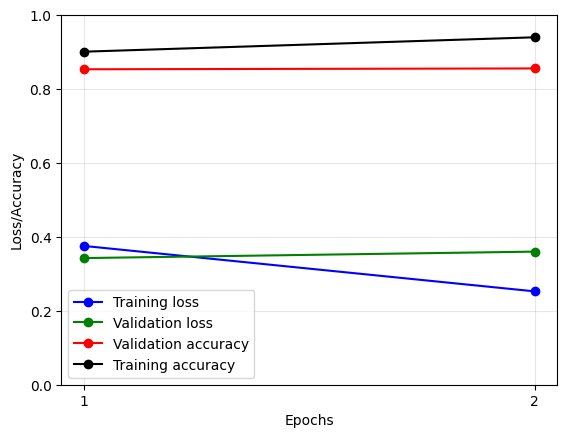

In [21]:
# Learning curve (2 epochs)
plt.grid(alpha=0.3)    # we don't want grid lines to be fully opaque

# plotting the points (best model)
plt.ylim(0, 1)      # Θέλουμε ο άξονας y που είναι το accuracy να ξεκινά από το μηδέν και να φτάνει μέχρι το ένα

plt.plot(df_stats['Training Loss'], 'b-o', label="Training loss")  
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation loss")  
plt.plot(df_stats['Valid. Accur.'], 'r-o', label="Validation accuracy") 
plt.plot(df_stats['Train. Accur.'], 'k-o', label="Training accuracy") 

plt.xticks([1, 2])

plt.xlabel('Epochs')  # naming the x axis  
plt.ylabel('Loss/Accuracy')       # naming the y axis  

plt.legend()
plt.savefig('learning-curve-final-2-epochs.png')

In [22]:
# Prediction on val set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions = []

# Predict
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)

# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)    # predictions = predictions across *all batches*
# For each sample, pick the label (0 or 1) with the higher score.
y_val_pred = np.argmax(flat_predictions, axis=1).flatten()

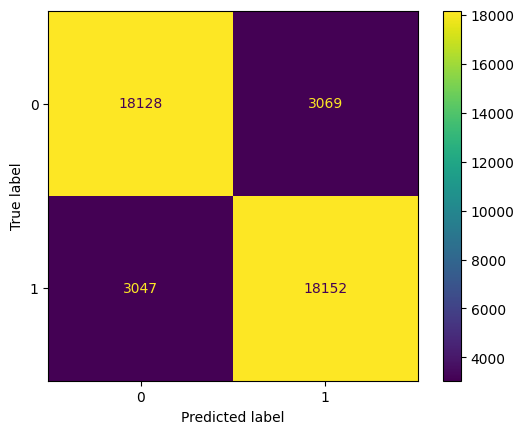

In [23]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, y_val_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1]) 
cm_display.plot()
plt.savefig('confusion-matrix-final.png')

In [24]:
# Classification report

# accuracy, recall, precision, f1 score
print("Classification Report:\n", classification_report(y_val, y_val_pred)) 

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     21197
           1       0.86      0.86      0.86     21199

    accuracy                           0.86     42396
   macro avg       0.86      0.86      0.86     42396
weighted avg       0.86      0.86      0.86     42396



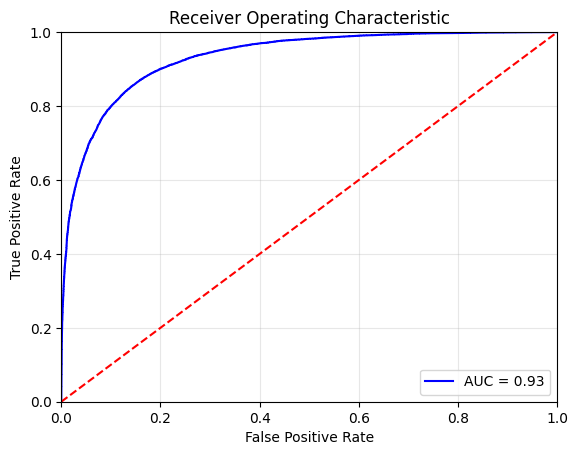

In [25]:
# ROC curve (best model)
y_val_probs = softmax(flat_predictions, axis=1)[:, 1]  # Probabilities for class 1 (softmax in every raw = values sum up to 1, and then we take only the second column) 

fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

plt.grid(alpha=0.3)    # we don't want grid lines to be fully opaque
plt.title('Receiver Operating Characteristic')
plt.grid(True)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc-curve-final.png')

# 4. 
Evaluation of test set

In [26]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_test:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len_sent,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Batch size is set from training

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks)     # we create a TensorDataset without the labels
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [27]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions = []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()

  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')

    DONE.


In [28]:
# Sumbmit test set

# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)    # predictions = predictions across *all batches*

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

df_test_submission = pd.DataFrame({'ID': X_test_id, 'Label' : flat_predictions})
df_test_submission.to_csv('submission.csv', index=False)